In [2]:
import random 
import numpy  as np

### Problema abordado
1. Aprendizado supervisioando de regressão multivariada 
2. Aprendizado em batch já que pegarei os dados farei todo o processor de treinamento e colocarei para produção

In [3]:
x = np.random.rand(100,1)*100
y = np.random.randn(100,1)*100

### Erro quadratico medio

$RMSE(X,h) = \sqrt{\frac{1}{m} \sum^{m}_{i=1}{h(x^{(i)} - y^{(i)})}}$

In [4]:
def Mean_Squared_Error(pred,y,squared=True):
    rmse = (1/np.size(y))*np.sum(pred-y)
    if (squared):
        return np.sqrt(rmse)
    return rmse

In [5]:
Mean_Squared_Error(x,y)

6.37036710351634

### Erro Absoluto Medio
$MAE(X,h) = \frac{1}{m} \cdot \sum^{m}_{i=1} | h(x^{(i)} - y^{(i)})|$

In [6]:
def Mean_Absolute_Error(pred,y):
    return (1/np.size(y))*abs(np.sum(pred-y))

In [7]:
Mean_Absolute_Error(x,y)

40.58157703356317

### R2

$\large R2(pred,ytrue) = 1-\frac{\sum^{m}_{i=1}({ytrue^{i} - pred^{i})^{2}}}{{\sum^{m}_{i=1}} ({ytrue^{i} - ytrue_{mean})^{2}} }$

In [8]:
def R2(pred,y):
    mean = np.mean(y)
    sum1 = sum2 = 0
    for i in range(np.size(pred)):
        sum1 += (y[i] - pred[i])**2
    for i in range(np.size(pred)):
        sum2 += (y[i] - mean)**2
    return abs(1 - (sum1/sum2))

In [9]:
R2(x,y)

array([0.44847476])

&nbsp;

### Problema

In [10]:
import warnings
import copy
import pandas as pd
import seaborn as sea 
import matplotlib.pyplot as plt

In [11]:
warnings.filterwarnings('ignore',category=pd.errors.SettingWithCopyWarning)

In [12]:
data = pd.read_csv(r'dataset/housing.csv',sep=',')

In [13]:
data.head(3)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY


&nbsp;

## Analise dos dados

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [15]:
data.isna().nunique()

longitude             1
latitude              1
housing_median_age    1
total_rooms           1
total_bedrooms        2
population            1
households            1
median_income         1
median_house_value    1
ocean_proximity       1
dtype: int64

> `total_bedrooms` possuem valores nulos , pré-processamento será necessario imputar dados
* SimpleImputer | Interative Inputer

In [16]:
data.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


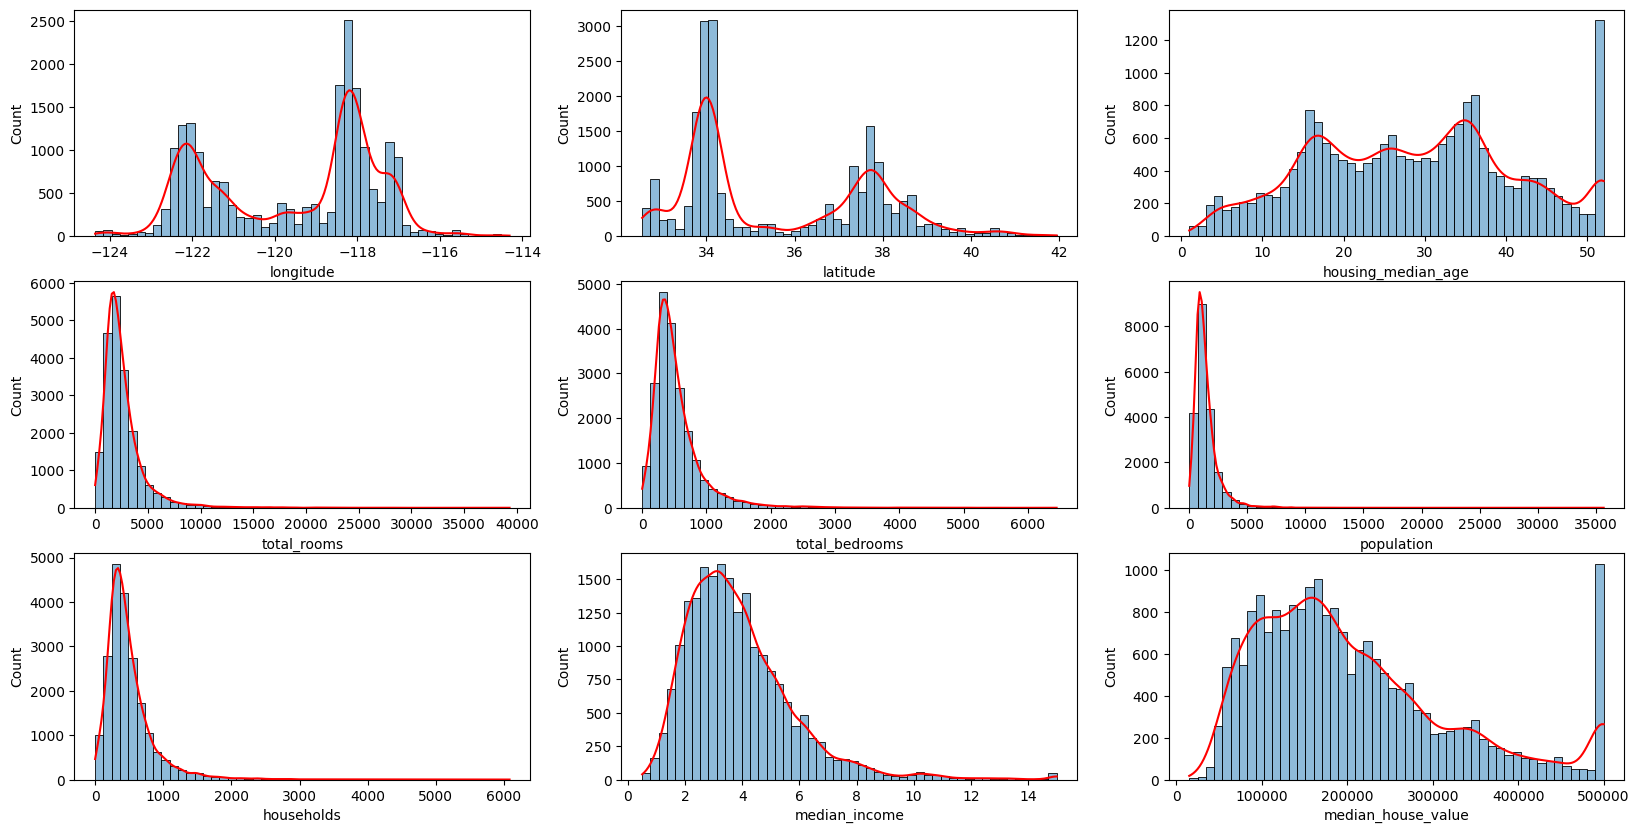

In [17]:
fig , axis = plt.subplots(3,3,figsize=(20,10))
columns    = data.select_dtypes(exclude=['object']).columns
for ax, column in zip(axis.flatten(),columns):
    hist = sea.histplot(data[column],ax=ax,bins=50,kde=True)
    hist.lines[0].set_color('red')
plt.show()

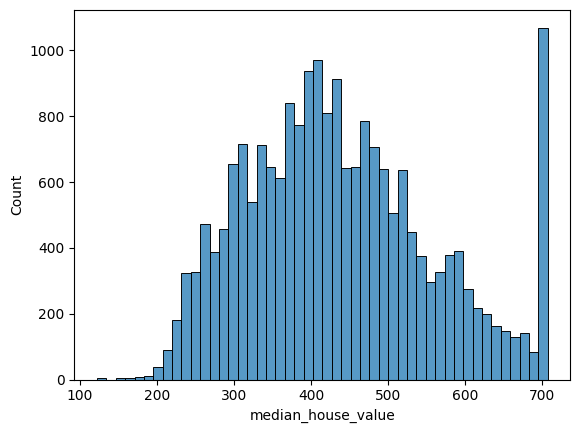

In [18]:
sea.histplot(np.sqrt(data['median_house_value']))
plt.show()

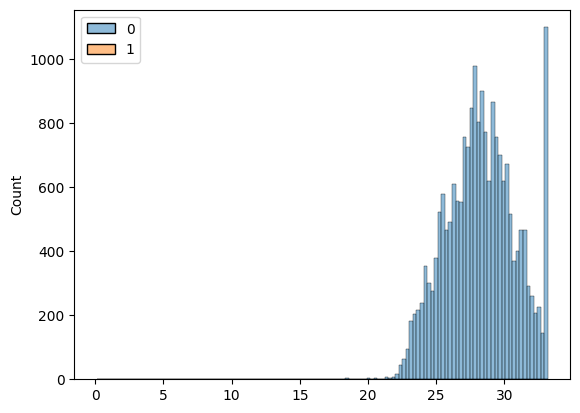

In [19]:
from scipy.stats import boxcox
sea.histplot(boxcox(data['median_house_value']))
plt.show()

> Atributos com calda longa

&nbsp;

## Pré-processamento

In [20]:
dataset = data.copy()

In [21]:
from sklearn.preprocessing import (
    StandardScaler
)
from sklearn.model_selection import (
    GridSearchCV        ,
    RandomizedSearchCV  ,
    train_test_split    ,
    StratifiedShuffleSplit
)

In [22]:
train , test = train_test_split(dataset,test_size=0.2,random_state=42)

In [23]:
dataset['income_cat'] = pd.cut(
    x      = data['median_income'],
    bins   = [0,1.5,3.0,4.5,6.,np.inf], 
    labels = [1,2,3,4,5]
    )

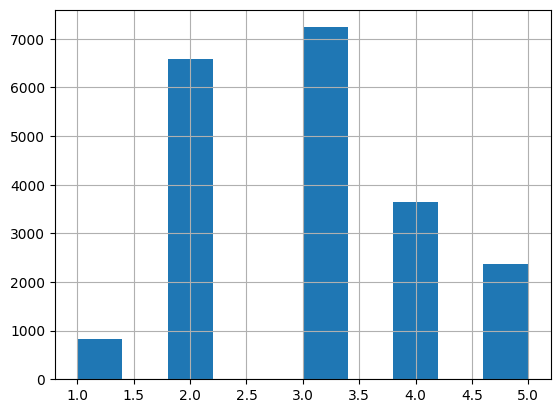

In [24]:
dataset['income_cat'].hist()
plt.show()

In [25]:
splitStratifed = StratifiedShuffleSplit(n_splits=1,test_size=0.2,random_state=42)

for itrain , itest in splitStratifed.split(dataset,dataset['income_cat']):
    trainf = dataset.iloc[itrain]
    testf  = dataset.iloc[itest]

In [26]:
trainf['income_cat'].value_counts().apply(lambda x: x/len(trainf))

income_cat
3    0.350594
2    0.318859
4    0.176296
5    0.114462
1    0.039789
Name: count, dtype: float64

In [27]:
housing = trainf.copy()

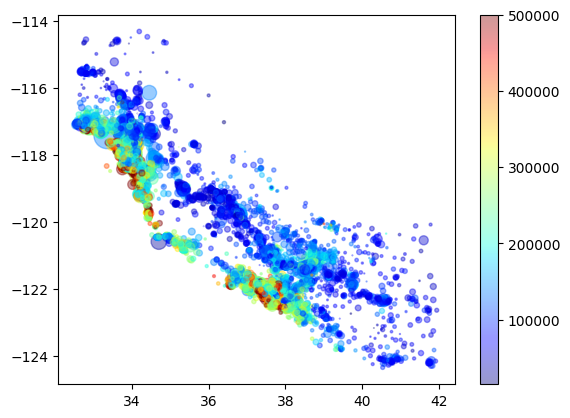

In [28]:
fig = plt.scatter(x =housing['latitude'] , y=housing['longitude'],alpha=0.4,s=housing['population']/100,c=housing['median_house_value'],cmap='jet')
plt.colorbar(fig)
plt.show()

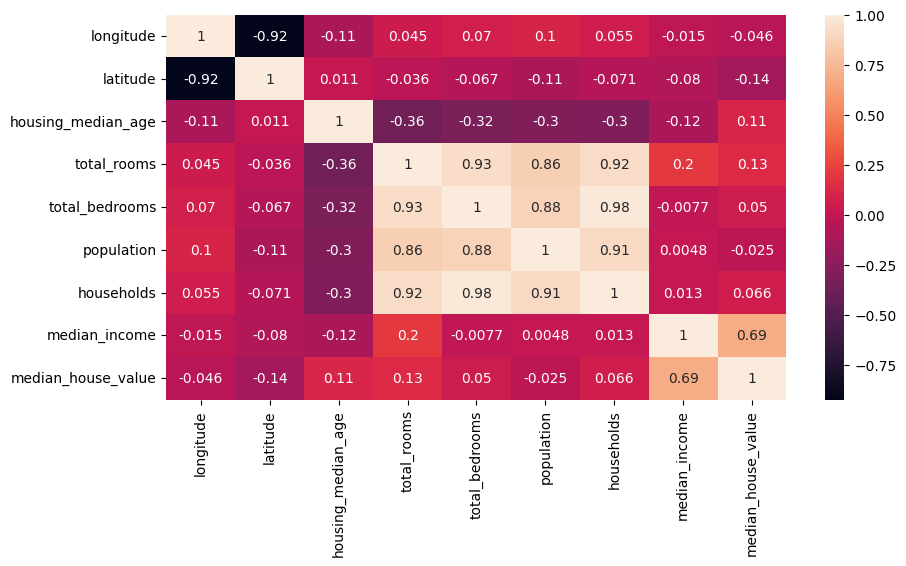

In [29]:
plt.figure(figsize=(10,5))
sea.heatmap(data.select_dtypes(exclude='object').corr(),annot=True)
plt.show()

&nbsp;

### Preparando os dados

In [30]:
housing        = trainf.drop(columns=['median_house_value'])
housing_labels = trainf['median_house_value']

imputando valores ausentes

In [31]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='median')
housing['total_bedrooms'] = imputer.fit_transform(housing['total_bedrooms'].values.reshape(-1,1))

Manipulando texto e atributos categoricos

In [32]:
from sklearn.preprocessing import OrdinalEncoder

Ordinal_Encoder = OrdinalEncoder()
Ordinal_Encoder.fit_transform(housing['ocean_proximity'].values.reshape(-1,1))

array([[1.],
       [4.],
       [1.],
       ...,
       [0.],
       [0.],
       [1.]])

In [33]:
from sklearn.preprocessing import OneHotEncoder

dummiesSk = OneHotEncoder()
array = dummiesSk.fit_transform(housing['ocean_proximity'].values.reshape(-1,1))
array.toarray()

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [34]:
from sklearn.base import BaseEstimator , TransformerMixin

In [35]:
class CombinedAtributes(BaseEstimator,TransformerMixin):
    def __init__(self,addBedrooms=True):
        self.addBedrooms = addBedrooms
    def fit(self,X,y = None):
        return self
    def transform(self,X,y=None):
        roomsIndex , bedroomsIndex ,populationIndex , houseHoldsIndex = 3,4,5,6

        roomsPorHousehold      = X[:,roomsIndex] /X[:,houseHoldsIndex]
        populationPorHousehold = X[:,populationIndex] /X[:,houseHoldsIndex]

        if (self.addBedrooms):
            bedroomsPorRoom = X[:,bedroomsIndex] / X[:,roomsIndex]

            return np.c_[X,roomsPorHousehold,bedroomsPorRoom,populationPorHousehold]
        
        return np.c_[X,roomsPorHousehold,populationPorHousehold]

In [36]:
from sklearn.pipeline import Pipeline
from sklearn.compose  import ColumnTransformer
from sklearn.metrics  import *

In [37]:
numberPipeline = Pipeline(
    steps=[
        ('imputer'     ,SimpleImputer(strategy='median')),
        ('atribsADD'   ,CombinedAtributes(False)),
        ('padronizaçõo',StandardScaler())
        ]
    )

In [38]:
fullPipeline = ColumnTransformer(
    transformers=[
        ('num',numberPipeline,['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income']),
        ('cat',OneHotEncoder(),['ocean_proximity'])
    ]
)

In [39]:
housing.drop(columns=['income_cat'],inplace=True)

In [40]:
prepared = fullPipeline.fit_transform(housing)

### treinando

In [41]:
from sklearn.linear_model import LinearRegression

In [42]:
reg = LinearRegression()
reg.fit(prepared,housing_labels)

LinearRegression()

In [43]:
xtest = housing.iloc[:,:9]
pred = reg.predict(fullPipeline.fit_transform(xtest))

In [44]:
pred

array([ 88308.5135735 , 304174.12243205, 154135.1578518 , ...,
       219767.06632238, 241233.47089298,  98297.4977197 ])

In [45]:
np.sqrt(mean_squared_error(housing_labels,pred))

68911.35422344579

In [46]:
mean_absolute_error(housing_labels,pred)

49871.48162635614

tree

In [47]:
from sklearn.tree import DecisionTreeRegressor

In [48]:
tree = DecisionTreeRegressor()
tree.fit(prepared,housing_labels)

DecisionTreeRegressor()

In [49]:
pred = tree.predict(fullPipeline.fit_transform(xtest))

In [50]:
mean_absolute_error(housing_labels,pred)

0.0

In [51]:
(mean_squared_error(housing_labels,pred))

0.0

&nbsp;

## Feito por min

In [52]:
dataset = data.copy()

In [53]:
dataset['income_cat'] = pd.cut(
    x      = data['median_income'],
    bins   = [0,1.5,3.0,4.5,6.,np.inf], 
    labels = [1,2,3,4,5]
    )

In [54]:
splitStratifed = StratifiedShuffleSplit(n_splits=1,test_size=0.2,random_state=42)

for itrain , itest in splitStratifed.split(dataset,dataset['income_cat']):
    train = dataset.iloc[itrain]
    test  = dataset.iloc[itest]

In [55]:
train.drop(columns='income_cat',inplace=True)
test.drop(columns='income_cat' ,inplace=True)

In [56]:
xtrain , xtest , ytrain , ytest = (
    train.drop(columns='median_house_value') ,
    test.drop( columns='median_house_value') ,
    np.sqrt(train['median_house_value']),
    np.sqrt(test['median_house_value'])
    )

In [57]:
xtrain = fullPipeline.fit_transform(xtrain)
xtest  = fullPipeline.fit_transform(xtest)

In [58]:
from sklearn.linear_model import LinearRegression,SGDRegressor

In [59]:
reg = LinearRegression()
reg.fit(xtrain,ytrain)
predReg = reg.predict(xtest)

In [60]:
print('Mean Absolute Error..:',mean_absolute_error(ytest,predReg))
print('Mean Squared Error...:',mean_squared_error(ytest,predReg))
print('R2...................:',r2_score(ytest,predReg))

Mean Absolute Error..: 52.93499744386617
Mean Squared Error...: 4872.820171055279
R2...................: 0.6736519689854925


In [61]:
gradiente = SGDRegressor(penalty='elasticnet',alpha=0.1,l1_ratio=0.2)
gradiente.fit(xtrain,ytrain)
predGrad = gradiente.predict(xtest)

In [62]:
print('Mean Absolute Error..:',mean_absolute_error(ytest,predGrad))
print('Mean Squared Error...:',mean_squared_error(ytest,predGrad))
print('R2...................:',r2_score(ytest,predGrad))

Mean Absolute Error..: 55.045287607176896
Mean Squared Error...: 5158.98337314482
R2...................: 0.6544867229324038


In [63]:
tree = DecisionTreeRegressor()
tree.fit(xtrain,ytrain)
predTree = tree.predict(xtest)

In [64]:
print('Mean Absolute Error..:',mean_absolute_error(ytest,predTree))
print('Mean Squared Error...:',mean_squared_error(ytest,predTree))
print('R2...................:',r2_score(ytest,predTree))

Mean Absolute Error..: 68.2427763097285
Mean Squared Error...: 9206.748055410264
R2...................: 0.38339524249689383
